In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device : {device}")

device : cuda


# Hyper parameters

In [3]:
num_epochs = 5
batch_size = 4
learning_rate = 0.001

# Dataset

In [4]:
# dataset has PILImage images of range [0, 1]
# we transform them to Tensor of normalized range [-1, 1]
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.5 ,0.5 ,0.5), (0.5 ,0.5 ,0.5)) # mean 0.5, stddev 0.5 for each RGB channels
    ]
)

train_dataset = torchvision.datasets.CIFAR10(root="/home/hslee/Desktop/Datasets/", train=True,
                                             download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root="/home/hslee/Desktop/Datasets/", train=False,
                                             download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ('plan', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(f"train_dataset.shape = {train_dataset.data.shape}")
print(f"test_dataset.shape = {test_dataset.data.shape}")

train_dataset.shape = (50000, 32, 32, 3)
test_dataset.shape = (10000, 32, 32, 3)


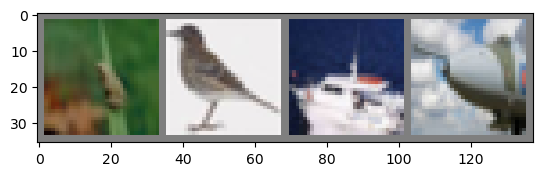

In [6]:
def imshow(img) :
    img = img / 2 + 0.5 # unnormalized
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

# Implement conv net

In [7]:
class ConvNet(nn.Module) :
    def __init__(self) :
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # input channel size is 3(RGB), output channel size is 6, kernel size is 5
        self.pool = nn.MaxPool2d(2, 2) # kernel size is 2, stride is 2
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2) # kernel size is 2, stride is 2
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # CIFAR-10 
        
        # checking dimension
        # ((W - F + 2P / S) + 1)   W : input Width, F : Filter Size, P : Padding, S : Stride
        # (3 * 32 * 32) --> conv1 : ((32 - 5 + 2*0 / 1) + 1) = 28 --> (6 * 28 * 28)
        # (6 * 28 * 28) --> pool  : ((28 - 2 + 2*0 / 2) + 1) = 28 --> (6 * 14 * 14)
        # (6 * 14 * 14) --> conv2 : ((14 - 5 + 2*0 / 1) + 1) = 28 --> (16 * 10 * 10)
        # (16 * 10 * 10) --> pool : ((10 - 2 + 2*0 / 2) + 1) = 28 --> (16 * 5 * 5)
        # fc1 : (16 * 5 * 5) x (120)
        # fc2 : (120) x (84)
        # fc3 : (84) x (10)
        
    def forward(self, x) :
        x = self.pool(F.relu(self.conv1(x))) # 1 conv layer
        x = self.pool(F.relu(self.conv2(x))) # 2 conv layer
        x = x.view(-1, 16 * 5 * 5) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # softmax is skipped. because it's already include in nn.CrossEntropyLoss().
        return x
        
        
model = ConvNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [8]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs) : 
    for i, (images, labels) in enumerate(train_loader) :
        # origin shape : [4, 3, 32, 32] = 4, 3, 1024
        # input layer : 3 input channels, 6 output channels, 5 kernel size
        images = images.cuda()
        labels = labels.cuda()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimze
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 2000 == 0 :
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss : {loss.item():.4f}")
            
print("Finished Training")
        

Epoch [1/5], Step [2000/12500], Loss : 2.3358
Epoch [1/5], Step [4000/12500], Loss : 2.3329
Epoch [1/5], Step [6000/12500], Loss : 2.3248
Epoch [1/5], Step [8000/12500], Loss : 2.2633
Epoch [1/5], Step [10000/12500], Loss : 2.1315
Epoch [1/5], Step [12000/12500], Loss : 2.0839
Epoch [2/5], Step [2000/12500], Loss : 2.8856
Epoch [2/5], Step [4000/12500], Loss : 1.6629
Epoch [2/5], Step [6000/12500], Loss : 1.9232
Epoch [2/5], Step [8000/12500], Loss : 2.2539
Epoch [2/5], Step [10000/12500], Loss : 1.8176
Epoch [2/5], Step [12000/12500], Loss : 1.9880
Epoch [3/5], Step [2000/12500], Loss : 2.4883
Epoch [3/5], Step [4000/12500], Loss : 0.5665
Epoch [3/5], Step [6000/12500], Loss : 1.3255
Epoch [3/5], Step [8000/12500], Loss : 2.4549
Epoch [3/5], Step [10000/12500], Loss : 1.3431
Epoch [3/5], Step [12000/12500], Loss : 1.3010
Epoch [4/5], Step [2000/12500], Loss : 1.2750
Epoch [4/5], Step [4000/12500], Loss : 1.2894
Epoch [4/5], Step [6000/12500], Loss : 1.3951
Epoch [4/5], Step [8000/1250

In [9]:
with torch.no_grad() :
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader :
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        
        # max returns (values, index)
        _, preds = torch.max(outputs, 1) # Only 1st maximum value
        n_samples += labels.size(0)
        n_correct += (preds == labels).sum().item() # item() : [10] -> 10
        
        for i in range(batch_size) :
            label = labels[i]
            pred = preds[i]
            if (label == pred) :
                n_class_correct[label] += 1 # For each class.. if correct? +1
            n_class_samples[label] += 1     # For each class.. +1
    
    acc = 100.0 * (n_correct / n_samples)
    print(f"Accuracy of the network : {acc} %")
    
    for i in range(10) :
        acc = 100.0 * (n_class_correct[i] / n_class_samples[i])
        print(f"Accuracy of {classes[i]} : {acc} %")

Accuracy of the network : 48.94 %
Accuracy of plan : 52.900000000000006 %
Accuracy of car : 60.6 %
Accuracy of bird : 25.8 %
Accuracy of cat : 13.900000000000002 %
Accuracy of deer : 34.4 %
Accuracy of dog : 55.50000000000001 %
Accuracy of frog : 68.0 %
Accuracy of horse : 67.0 %
Accuracy of ship : 52.0 %
Accuracy of truck : 59.3 %
